# Assignmnent 1 DRM

#### by Dag Stabell Storhaug, Kristian Wang Høiem, Paul Joakim Andreassen, og Espen Sønneland

## Abstract

In this project our group has made a series of programs to find the optimal way for a household to schedule their shiftable electrical appliances. A shiftable appliance is defined as an electrical appliance that isn’t required to be switched on at specific points of the day. Such as charging of an electrical vehicle, a water heater or a laundry machine. 
Conversely, a non-shiftable appliance means they cannot be rescheduled to another timeslot in the day. For instance the lights in a house needs to be on whenever people are home and it’s dark outside, or a refrigerator or freezer needs to be on all day. Each house has a limit to how much power the household can consume, wich will be set by the main breaker switch.

Two different pricing schemes are considered in this assignment. Time of Use pricing (ToU), where we assume that the price is 0.50NOK/kWh in non-peak hours and 1.00NOK/kWh in peak hours, and Real Time Pricing (RTP), where the price is set as a random number in a certain interval. The interval is different for peak hours and off-peak hours.

The pricing scheme considered in all tasks is assumed to be set 24 hours in advance to make the assignment easier for ourselves. It is easier to assign timeslots for appliances when we know what the price will be at each hour of the day.

Optimization has been done through the function "scipy.optimize.linprog" on a matrix containing all household appliances to find the optimal schedule to get the lowest electrical bill. The folowing constraints are applied:
* Maximum energy drawn by each appliance each hour.
* Each appliance needs to use a certain amount of energy each day
* Maximum total energy available to the household each hour.
* The majority of the appliances has a randomised interval to generate realistic varity.  


## Imports

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from numpy.linalg import solve
from random import shuffle
from random import seed
import random

## The Code

In [49]:
hours = 24
peak_hour_from = 17
peak_hour_to = 20
num_appl = 3 # Number of appliances

dishwasher     = np.zeros(num_appl*hours) #[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
washingmachine = np.zeros(num_appl*hours)  #[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
EV             = np.zeros(num_appl*hours) #[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

dishwasher[:24] = 1
washingmachine[24:48] = 1
EV[48:] = 1

TotalEnergyConsumption_dishwasher = 1.44 # kWh
TotalEnergyConsumption_washingmacine = 1.94  # kWh
TotalEnergyConsumption_EV = 9.9 # kWh


maxPowerUsage_dish = 1.8 # kW brukt per time
maxPowerUsage_wash = 0.5 # kW brukt per time
maxPowerUsage_EV = 3.6 # kW brukt per time 
maxPowerusage_total = 10 # kW brukt per time

price = np.ones(hours)*0.5
price[peak_hour_from:peak_hour_to] = 1 # peak-hour 5pm-8pm

A_eq = np.array([                        # Hvilke dingser som brukes i likhetsbegrensningen
                dishwasher,
                washingmachine,
                EV
])

b_eq = np.array([TotalEnergyConsumption_dishwasher,      # Summen av likhetsbegresningen
                 TotalEnergyConsumption_washingmacine,
                 TotalEnergyConsumption_EV
])


A_mul = np.zeros((hours,num_appl*hours))
for i in range(A_mul.shape[0]):
    A_mul[i,i::hours] = 1
A_one = np.eye(num_appl*hours)    
A_ub = np.concatenate((A_one,A_mul),axis=0)  # Hvilket timesobjekt begrensningen hører til 


b_one_ub = np.array( [maxPowerUsage_dish]*hours    # Begrensning
                    +[maxPowerUsage_wash]*hours
                    +[maxPowerUsage_EV]*hours
)
b_max_ub = np.array([maxPowerusage_total]*hours)

b_ub = np.concatenate((b_one_ub,b_max_ub)) 

c = np.array([])  #np.array([p1,p2,p3,p4,p1,p2,p3,p4]) Coefficients of the linear objective function to be minimized
for _ in range(num_appl):
    c = np.append(price,c)

res = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=(0, None))
print('Optimal value:', res.fun, '\nX:\n', res.x.reshape(num_appl,hours))


Optimal value: 6.64 
X:
 [[ 1.44  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.5   0.5   0.5   0.44  0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 3.6   3.6   2.7   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]]


In [50]:
def random_float(a=0, b=0):
    '''
    Takes two floating point numbers and returns a floating point number between these numbers. 
    '''
    return float((b-a)*np.random.random_sample(1) + a)

def interval(hour=1, start=0, stop=23, shuffle=False):
    '''
    Distributes the available hours where the appliance can be turned on, within the given interval, 
    from either start->stop, or within the timespan for the entire day
    '''
    if shuffle:
        interval = np.zeros(24)
        interval[:hour] = 1    
        np.random.shuffle(interval)
        return interval
    else:
        interval = np.zeros(stop-start + 1)
        interval[:hour] = 1
        np.random.shuffle(interval)
        if start == 0:
            padLeft = np.zeros(0)
        else:
            padLeft = np.zeros(start)
        if stop == 23:
            return np.append(padLeft,interval)
        else:
            padRight = np.zeros(24-len(interval)-len(padLeft))
            return np.append(np.append(padLeft,interval),padRight)
        
def pricing_scheme(rtp=False):
    #static pricing scheme
    if not rtp:
        price = np.array([
            0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
            0.5, 0.5, 0.5, 0.5, 1, 1, 1, 1, 0.5, 0.5, 0.5
        ])
    #real time pricing scheme, as determined by random numbers
    elif rtp:
        price = np.array([
            random_float(0.2, 1), random_float(0.2, 1),
            random_float(0.2, 1), random_float(0.2, 1),
            random_float(0.2, 1), random_float(0.2, 1),
            random_float(0.2, 1), random_float(0.2, 1),
            random_float(0.2, 1), random_float(0.2, 1),
            random_float(0.2, 1), random_float(0.2, 1),
            random_float(0.2, 1), random_float(0.2, 1),
            random_float(0.2, 1), random_float(0.2, 1),
            random_float(0.2, 1), random_float(0.8, 2),
            random_float(0.8, 2), random_float(0.8, 2),
            random_float(0.8, 2), random_float(0.2, 1),
            random_float(0.2, 1), random_float(0.2, 1)
        ])
    return price

def seed(seed=False,):
    if seed:
        np.random.seed(seed)
    else:
        pass

In [73]:
#Creates a stacked bargraph. putting the values of the np.array 'nonshift' at
# the bottom and the values of np.array 'shift' on top.
def power_plots(shift=None, nonshift=None, shiftnames=None,
                     nonshiftnames=None, price=None):
    f, (consumptionfig) = plt.subplots(1, 1, figsize=(10,7))
    
    if shift is not None:
        length = len(shift[0])
    elif nonshift is not 0:
        length = len(nonshift[0])
    elif price is not None:
        length = len(price)
    bins = np.arange(0, length)
    width = 0.9
    bottom = np.zeros(length)

    #iterate over shiftable and nonshiftable appliances to create stacked
    # bars for the chart.
    if nonshift is not 0:
        for i in range(len(nonshift)):
            consumptionfig.bar(bins, nonshift[i], width=width, bottom=bottom,
                               label=nonshiftnames[i])
            bottom = np.add(bottom, nonshift[i])
    if shift is not None:
        for i in range(len(shift)):
            consumptionfig.bar(bins, shift[i], width=width, bottom=bottom,
                               label=shiftnames[i])
            bottom = np.add(bottom, shift[i])

    consumptionfig.set(
        title='Consumption of households',
        xlabel='Hour',
        xticks=bins,
        ylabel='Consumption, kWh'
        )

    #Making the figure pretty
    consumptionfig.tick_params(axis="both", which="both", bottom="off",
                               top="off", labelbottom="on", left="off",
                               right="off", labelleft="on")
    consumptionfig.spines["top"].set_visible(False)
    consumptionfig.spines["bottom"].set_visible(False)
    consumptionfig.spines["right"].set_visible(False)
    consumptionfig.spines["left"].set_visible(False)
    consumptionfig.set_axisbelow(True)
    consumptionfig.grid(b=True, which='major', axis='y', color='#cccccc',
                        linestyle='--')

    if price is not None:
        pricefig = consumptionfig.twinx()
        pricefig.step(bins, price, color='black', where='mid', label='price')
        pricefig.set(ylabel='Price, NOK/kWh')
        pricefig.spines["top"].set_visible(False)
        pricefig.spines["bottom"].set_visible(False)
        pricefig.spines["right"].set_visible(False)
        pricefig.spines["left"].set_visible(False)
        consumptionfig.set_axisbelow(True)
        
    #retrieving labels to make a neat legend
    handles, labels = consumptionfig.get_legend_handles_labels()
    handle, label =pricefig.get_legend_handles_labels()
    consumptionfig.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
    pricefig.legend(bbox_to_anchor=(1.15, 0), loc=2, borderaxespad=0.)

    plt.tight_layout()
    plt.show()

In [74]:
class House():

    def construct(self,price=[], task=1):
        '''
        Choosing non-shiftable and shiftable appliances, and random 
        selection of optional appliances. Optimizing the shiftable 
        appliance scheduling with constraints. 
        '''
        app_df = self.appliances()
        
        # Splitting dataframe into shiftables and non-shiftables
        app_shift = app_df[app_df['shiftable'] == 1]
        app_nonshift = app_df[app_df['shiftable'] == 0] 
            
        # Splitting into optional and non-optional appliances
        app_nonshift = app_nonshift[app_nonshift['optional'] == 0]
        app_optional = app_df[app_df['optional'] == 1]
        
        # Random selection of optional appliances
        app_optional = self.choose_optional(app_optional)
        
        # An unique selection of non-shiftable appliances
        app_nonshift_total = app_nonshift.append(app_optional)
        
        # Getting the consumption of non-shiftable and shiftable appliances
        if task == 1:
            nonshift_consumption_total = np.zeros(24)
            nonshift_consumption = 0
        else:
            # Random selection of EV 
            if task is not 2 and random_float(0, 1) > 0.2:
                app_shift.drop(['EV'],inplace=True)
            nonshift_consumption_total, nonshift_consumption = self.get_nonshift_consumption(app_nonshift_total)
        shiftable_consumption = app_shift['consumption'].values
        maxEnergy = app_shift['maxEnergy'].values
        
        # Names of non-shiftable and shiftable appliances
        app_nonshift_label = app_nonshift_total.index
        app_shift_label = app_shift.index
        
        # Intervals for when shiftable appliances can be on 
        intervals = app_shift['interval'].values.ravel()
        
        # Opimiztion and scheduling of shiftable appliances 
        optimal_value, shiftable_consumption_scheduling, name= self.opt(name=app_shift_label, 
                                                                         consumption=shiftable_consumption, 
                                                                         maxEnergy=maxEnergy,
                                                                         maxEnergy_total=4.5,
                                                                         intervals=intervals, 
                                                                         nonshift_consumption=nonshift_consumption_total, 
                                                                         price=price)
        
        return optimal_value, app_shift_label, shiftable_consumption_scheduling, app_nonshift_label, nonshift_consumption, nonshift_consumption_total, price
    
    def choose_optional(self,app_optional):
        '''
        Choosing optional non-shiftable appliances 
        '''
        index = []
        for i in range(len(app_optional)):
            if np.random.randint(0,2):
                index.append(app_optional.iloc[i])
        return pd.DataFrame(index)

    def appliances(self):  
        '''
        Returns a dataframe with appliances as indexes and properties such as energy consumption as columns.
        '''
        Appliances = {
            'Heating':{
                 'consumption': random_float(6.4,9.6), 
                 'maxEnergy':0,
                 'interval': np.ones(24), 
                 'shiftable': 0,
                 'optional': 0
            },
            'Refrigerator_Freezer':{
                'consumption': random_float(1.32,3.96), 
                'maxEnergy':0,
                'interval': np.ones(24), 
                'shiftable': 0,
                'optional': 0
            },
            'Stove':{
                'consumption': 3.9,
                'maxEnergy': 2.2,
                'interval': interval(2,14,19), 
                'shiftable': 0,
                'optional': 0
            },
            'Dishwasher':{
                'consumption': 1.44, 
                'maxEnergy': 1.8,
                'interval': np.ones(24), 
                'shiftable': 1,
                'optional': 0
            },
            'LaundryMachine':{
                'consumption': 1.94,
                'maxEnergy' : 0.5,
                'interval': np.ones(24), 
                'shiftable': 1,
                'optional': 0
            },
            'EV':{
                'consumption': 9.9,
                'maxEnergy': 3.6,
                'interval': [1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1], 
                'shiftable': 1,
                'optional': 0
            },
            'ClothDryer':{
                'consumption': 2.5,
                'maxEnergy': 3.0,
                'interval': np.ones(24), 
                'shiftable': 1,
                'optional': 0
            },
            'Tv':{
                'consumption': random_float(0.15, 0.6),
                'maxEnergy': 0.1,
                'interval': interval(5), 
                'shiftable': 0,
                'optional': 0
            },
            'Computer':{
                'consumption': 0.6,
                'maxEnergy': 0.1,
                'interval': interval(6), 
                'shiftable': 0,
                'optional': 0
            },
            'CoffeeMaker':{
                'consumption': 3.0,
                'maxEnergy': 1.5,
                'interval': interval(2), 
                'shiftable': 0,
                'optional': 1
            },
            'CeilingFan':{
                'consumption': 0.45,
                'maxEnergy': 0.075,
                'interval': interval(6,16,22), 
                'shiftable': 0,
                'optional': 1
            },
            'HairDryer':{
                'consumption': 0.15,
                'maxEnergy': 1.5,
                'interval': interval(1,5,21),  
                'shiftable': 0,
                'optional': 1
            },
            'Toaster':{
                'consumption': 0.22,
                'maxEnergy': 1.2,
                'interval': interval(1,7,12), 
                'shiftable': 0,
                'optional': 1
            },
            'Microwave':{
                'consumption': 0.6,
                'maxEnergy': 1.2,
                'interval': interval(1,6,21), 
                'shiftable': 0,
                'optional': 1
            },
            'Router':{
                'consumption': 0.144,
                'maxEnergy': 0.006,
                'interval': np.ones(24), 
                'shiftable': 0,
                'optional': 1
            },
            'CellphoneCharge':{
                'consumption': 0.015,
                'maxEnergy': 0.005,
                'interval': interval(3), 
                'shiftable': 0,
                'optional': 1
            },
            'ClothIron':{
                'consumption': 0.275,
                'maxEnergy': 1.1,
                'interval': interval(1,16,23), 
                'shiftable': 0,
                'optional': 1
            },
            'SeparateFreezer':{
                'consumption': 4.8,
                'maxEnergy': 0.2,
                'interval': np.ones(24),
                'shiftable': 0,
                'optional': 1
            },
            'Lighting':{
                'consumption': random_float(1.0,2.0),
                'maxEnergy': 0.06,
                'interval': interval(10,10,20), 
                'shiftable': 0,
                'optional': 0
            }
        }

        Appliances_df = pd.DataFrame.from_dict(data=Appliances, orient='index')  

        return Appliances_df   

    def get_nonshift_consumption(self, app_df):    
        '''

        '''
        nonShiftableUsage = np.zeros(24)
        nonShiftables = app_df[app_df['shiftable'] == 0]
        nonShiftables['consumption_h'] = pd.Series(np.zeros(len(nonShiftables['consumption'])), index=nonShiftables.index)

        interval_hours_sum = []
        
        for i in range(len(nonShiftables)):
            h = np.sum(nonShiftables['interval'][i])
            interval_hours_sum.append(h)
            if h:
                nonShiftables['consumption_h'][i] = nonShiftables['consumption'][i]/h
        
        # Hourly consumption scheduling for each non-shiftable        
        hourly_consumption = (nonShiftables['consumption']/interval_hours_sum)*nonShiftables['interval']
        hourly_consumption = hourly_consumption.values
        
        # Total hourly consumption for non-shiftables 
        hourly_consumption_total = np.zeros(24)
        for i in range(len(nonShiftables)):
            for j in range(24):
                hourly_consumption_total[j] += nonShiftables['interval'][i][j]*nonShiftables['consumption_h'][i]

        return hourly_consumption_total, hourly_consumption


    def opt(self, name=None, consumption=0.0, maxEnergy=0.0, intervals=None, 
            price=[], maxEnergy_total=5,nonshift_consumption=[]):
        '''
        Optimises the daily cost related to energy consumption for a house with x appliances.

        Returns the optimal value and a matrix [number of appliances x hours of the day] consisting of hourly energy values, with rows 
        and columns corresponding to objects and hours of the day, respectively.

        ---------------------------------
        Linear programming of the problem:

        minimise f(x) = c1x1_1 + c2x1_2 + c3x1_3 +..+ cnx1_n + c1x2_1 + c2x2_2 + c3x2_3 +..+ cnx2_n +..+ c1xm_1 + c2xm_2 + c3xm_3 +..+ cnxm_n
        s.a.

        x1_1 + x1_2 +x1_3 +..+ x1_n = consumption1
        x2_1 + x2_2 +x2_3 +..+ x2_n = consumption2
                            .
                            .
        xm_1 + xm_2 + xm_3 +..+ xm_n = consumptionm

        x1_1 <= maxEnergy1
        x1_2 <= maxEnergy1
        x1_3 <= maxEnergy1
                .
        x1_n <= maxEnergy1
        x2_1 <= maxEnergy2
        x2_2 <= maxEnergy2
        x2_3 <= maxEnergy2
                .
        x2_n <= maxEnergy2
        xm_1 <= maxEnergym
        xm_2 <= maxEnergym
        xm_3 <= maxEnergym
                .
        xm_n <= maxEnergym

        x1_1 + x2_1 +..+ xm_1 <= maxEnergy_total
        x1_2 + x2_2 +..+ xm_2 <= maxEnergy_total
                            .
        x1_n + x2_n +..+ xm_n <= maxEnergy_total

        x >= 0


        '''

        # Initialising 
        hours = 24
        peak_hour_from = 17
        peak_hour_to = 20
        num_appl = len(name) # Number of appliances

        #maxEnergyusage_total = 10 # kW brukt per time

        #price = np.ones(hours)*0.5
        #price[peak_hour_from:peak_hour_to] = 1 # peak-hour 5pm-8pm

        # Initialising hourly appliance consumption matrix used for optimisation
        A_eq = np.zeros((num_appl, num_appl*hours))

        # Assigns which element should correspond to a given appliance keeping the order.

        shift = 0
        for i in range(num_appl):
            for j in range(hours):
                A_eq[i,j+(hours*i)] = intervals[i][j]

        #for i in range(num_appl):

           # A_eq[i,i*hours:(i+1)*hours] = interval[i,:]

        # The sum of equality constraints  
        b_eq = consumption

        # Which time object the constraints belong to.
        A_mul = np.zeros((hours,num_appl*hours))
        for i in range(A_mul.shape[0]):
            A_mul[i,i::hours] = 1
        A_one = np.eye(num_appl*hours)    
        A_ub = np.concatenate((A_one,A_mul),axis=0)

        # Constraints
        b_one_ub = []
        for i in range(num_appl):
            b_one_ub += [maxEnergy[i]]*hours
        b_one_ub = np.array(b_one_ub)
        b_max_ub = np.ones(hours)*maxEnergy_total
        #print(b_max_ub)
        b_max_ub -= nonshift_consumption
        #print(nonshift_consumption)

       # print(b_max_ub)
        b_ub = np.concatenate((b_one_ub,b_max_ub)) 

        # Price coefficents of the linear objective function to be minimized
        c = np.array([])
        for _ in range(num_appl):
            c = np.append(price,c)

        res = linprog(c, A_eq=A_eq, b_eq=b_eq, A_ub=A_ub, b_ub=b_ub, bounds=(0, None))
        #print('Optimal value:', res.fun, '\nX:\n', res.x.reshape(num_appl,hours))

        return res.fun, res.x.reshape(num_appl,hours), name

## Task 1

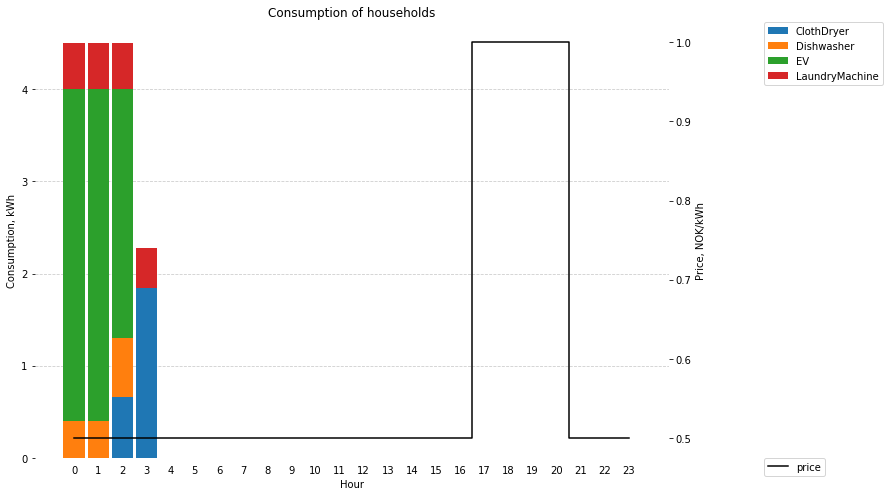

"\nseed = 12\napp_df = appliances()\n\nnonshift_consumption = get_nonshift_consumption(app_df)\nprint(app_df)\napp_shift = app_df[app_df['shiftable'] == 1]\nconsumption = app_shift['consumption'].values\nmaxEnergy = app_shift['maxEnergy'].values\nintervals = app_shift['interval'].values.ravel()\napp_label = app_shift.index\nprint(interval)\nopt(name=app_label, consumption=consumption, maxEnergy=maxEnergy, intervals=intervals, nonshift_consumption=nonshift_consumption)\n"

In [75]:
seed()
price=pricing_scheme(rtp=False)
house = House()
#house.construct(price)

total_price, shift_names, shift_consumption, nonshift_names, nonshift_consumption, nonshift_consumption_total, price = house.construct(price)
power_plots(shift_consumption, nonshift_consumption, shift_names, nonshift_names, price)

'''
seed = 12
app_df = appliances()

nonshift_consumption = get_nonshift_consumption(app_df)
print(app_df)
app_shift = app_df[app_df['shiftable'] == 1]
consumption = app_shift['consumption'].values
maxEnergy = app_shift['maxEnergy'].values
intervals = app_shift['interval'].values.ravel()
app_label = app_shift.index
print(interval)
opt(name=app_label, consumption=consumption, maxEnergy=maxEnergy, intervals=intervals, nonshift_consumption=nonshift_consumption)
'''

### Discussion

First step was to construct the appliances for a simple household. The majority of the appliance has a random interval generator to create variance. The linear optimiser program uses constraints to limit the maximal usage of energy consumption for a given hour. This takes into consideration total energy consumption for a specific appliance per day, max energy consumption for a specific appliance per hour, and the total max energy consumption for each hour. 

The pricing follows a time of usage (ToU) schedule, so we create an array with a set interval of peak and off-peak hours. When we optimize, we multiply the energy consumption with the price of the hour. This favours the appliances to be on at off-peak hours.

When optimizing with linprog, the function needs a matrix as an input. The matrix we send in has the shape shown in the figures below:




<img src="./matrixleq.jpg" width="800" height="160">
<img src="./matrixeq.jpg" width="800" height="160">

When we look at the figure we see that all the appliances are turned on early and consectutively. This is not surprising, as this is off-peak hours, and as all off-peak hours are equally priced the program prefers early hours. This model will allways put shiftable appliances in the earliest off-peak hours, and then only the peak hours if forced.

## Task 2

C:\Users\Dag\Anaconda3\lib\site-packages\ipykernel_launcher.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


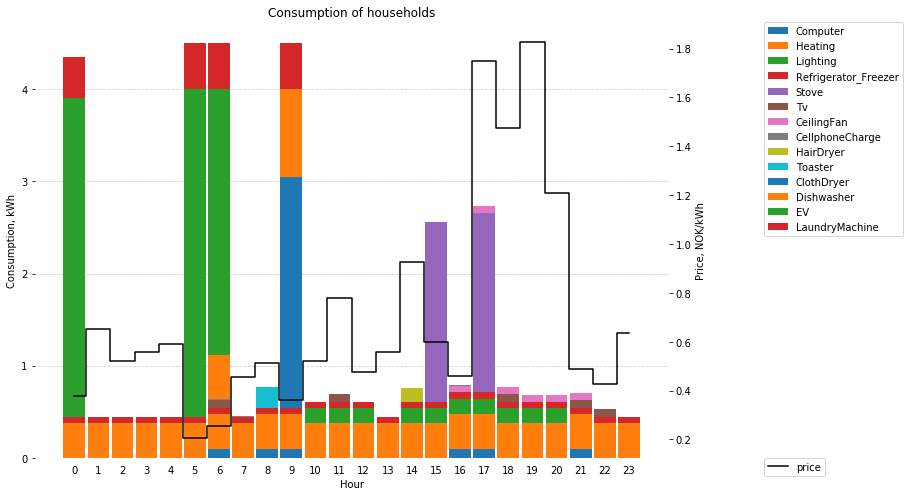

In [76]:
seed()
price=pricing_scheme(rtp=True)
house = House()

total_price, shift_names, shift_consumption, nonshift_names, nonshift_consumption, nonshift_consumption_total, price = house.construct(price, task=2)
power_plots(shift_consumption, nonshift_consumption, shift_names, nonshift_names, price)

### Discussion

For the second task of the assignment, the house was equipped with a set list of non-shiftable and shiftable appliances. A few optional non-shiftable appliances was added through random selection.

Typical energy consumpion of the appliances was found through the website http://energyusecalculator.com/.

Pricing scheme considered for this calculation was an RTP-scheme, where the price in non-peak hours is a random number between 0.20 and 1.00NOK/kWh every hour, and in peak hours the price is a random number between 0.80 and 2.00NOK/kWh.

The optimization was done through the same process as in task 1.
In this task however, the total energy available to the shiftable appliances is the total available energy with the energy used by non-shiftable application subtracted.


## Task 3

C:\Users\Dag\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Dag\Anaconda3\lib\site-packages\ipykernel_launcher.py:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


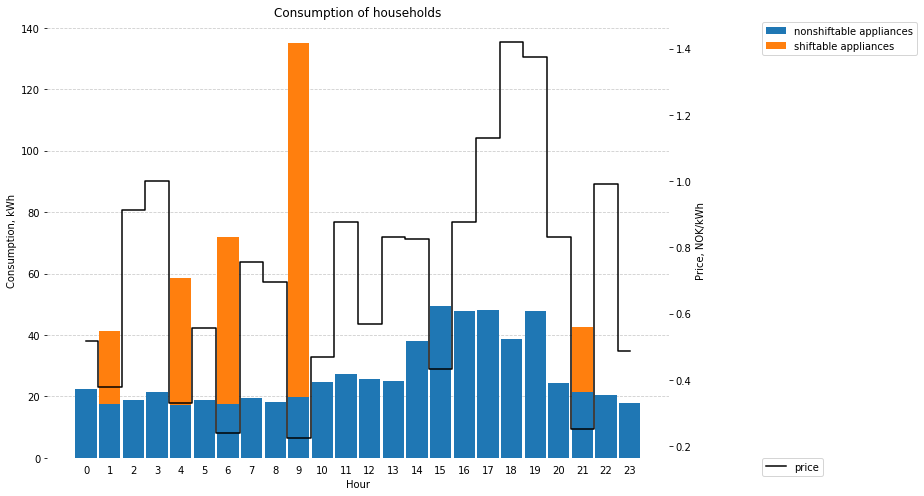

66.7870396368


In [82]:
shift_hood = np.zeros(24)
nonshift_hood = np.zeros(24)
price=pricing_scheme(rtp=True)
hood_price=0
num_houses = 30


for _ in range(num_houses):
    total_price, shift_names, shift_consumption, nonshift_names, nonshift_consumption, nonshift_consumption_total, _  = house.construct(price, task=3)
    total_shift = [shift for shift in shift_consumption]
    shift_hood += np.sum(total_shift, axis=0)
    total_nonshift = [nonshift for nonshift in nonshift_consumption]
    nonshift_hood += np.sum(total_nonshift, axis=0)
    hood_price += total_price

#shows the schedule of shiftable and nonshiftable appliances, and the cumulative power bill of entire neighborhood for 24h
power_plots([shift_hood], [nonshift_hood], ['shiftable appliances'], ['nonshiftable appliances'], price)
print(hood_price)
    

### Discussion

In this task a neighborhood of 30 randomly generated households was constructed one by one. In the figure all shiftable appliances of all 30 houses are added together, then the non-shiftable appliances are added together as well. This is to get an idea of how the neighborhood chooses to schedule their power. The optimization of each house is done as in task 2.

From the figure, it is apparent that most household chooses to schedule most of their optional power-use in hours with the lowest price. The reason for this is that the houses does not take their neighbors power usage into consideration when scheduling their own usage.

The total power bill of the neighborhood varies from run to run. This is to be expected, as number and type of appliances of the neighborhood as well as price is random for each run.

## Conclusion

Our ToU-model has the energy usage compressed in the off-peak hours, while the RTP-models are far more complex and has the usage more spread throughout the day. This is a result of the ToU-model having large differences between off-peak and peak hours, and the RTP-model having a varying price schedule.

An important detail is that each house in task 3 does not consider the usage of its neighbours. This results in a very large peak of power usage when the price is at its lowest. In a large city, this will be a problem, as the power demand would quickly exceed the capasity of the powerlines.

A weakness in the proposed solution is that certain appliances that should be powered in consecutive hours, such as a laundry machine or clothes dryer, is sometimes powered in disconnected intervals of the day. As a result our final electrical bill will probably be slightly lower than a realistic household, since our appliances can choose not to run consecutively. To solve this, there would have to be a constraint in the linprog-function that made sure that certain appliances would be powered consecutively.